In [ ]:
#This notebook is used to reproduce the findings in this paper: https://www.sciencedirect.com/science/article/pii/S2352914821000356
#Elujide, Israel, et al. "Application of deep and machine learning techniques for multi-label classification performance on psychotic disorder diseases." Informatics in Medicine Unlocked 23 (2021): 100545.

#This paper doesn't provide any code repo

#The libraries include torch, pandas, numpy, matplotlib, imbalanced-learn and sklearn.

#Data can be downloaded from this paper's supplementary material:
#https://www.sciencedirect.com/science/article/pii/S2352340917303487

#Preprocessing code: 0. SMOTE.ipynb

#Imbalanced dataset training and validation: 1_imbalanced data_train+eval.ipynb

#Balanced dataset training and validation: 2_balanced data_train+eval.ipynb

#Pretrained model: see .pt files

In [179]:
import pandas as pd
import numpy as np
import matplotlib
import sklearn
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import random
import os
from tqdm import tqdm

In [242]:
# set seed
seed = 24
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)

In [251]:
batch_size = 50
class MyDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)
        print(self.data.columns)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        # Get the row at the specified index
        row = self.data.iloc[index]
        
        # Extract the features and label
        features = row[1:-5].values.astype(float)
        label = row[-5:]
        
        # Convert the label to a tensor
        label_tensor = torch.tensor(label)
        
        # Convert the features to a tensor
        features_tensor = torch.tensor(features)
        
        # Return the features and label as a tuple
        return features_tensor, label_tensor


imb_data = MyDataset('./data_imbalanced.csv')

imb_train_size = int(0.7 * len(imb_data))
imb_val_size = len(imb_data) - imb_train_size
imb_train_data, imb_val_data = torch.utils.data.random_split(dataset = imb_data, lengths = [0.7, 0.3 ])
imb_train_loader = DataLoader(imb_train_data, batch_size=batch_size, shuffle=True)
imb_val_loader = DataLoader(imb_val_data, batch_size=batch_size, shuffle=False)

print(len(imb_train_data), len(imb_val_data))

for batch in imb_val_loader:
  print((batch[0][0].dtype))


Index(['Unnamed: 0', 'agecode', 'sex_F', 'sex_M', 'faNoily_status_No',
       'faNoily_status_Yes', 'religion_C', 'religion_M', 'religion_O',
       'occupation_ARTISAN', 'occupation_C/SERVANT', 'occupation_FORCE',
       'occupation_RETIRED', 'occupation_STUDENT', 'occupation_UNEMPLYD',
       'genetic_No', 'genetic_Yes', 'status_M', 'status_S',
       'loss_of_parent_No', 'loss_of_parent_Yes', 'divorse_No', 'divorse_Yes',
       'Injury_No', 'Injury_Yes', 'Spiritual_consult_No',
       'Spiritual_consult_Yes', 'Insominia', 'shizopherania',
       'vascula_demetia', 'ADHD', 'Bipolar'],
      dtype='object')
350 150
torch.float64
torch.float64
torch.float64


In [291]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        
        self.fc1 = nn.Linear(26, 15)
        self.fc2 = nn.Linear(15, 20)
        #self.dropout = nn.Dropout1d(0) #0, 0.2, 0.4
        self.fc3 = nn.Linear(20, 20)
        self.fc4 = nn.Linear(20, 40)
        self.fc5 = nn.Linear(40, 5)

    def forward(self, x):
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        x = nn.functional.relu(x)
        #x = self.dropout(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = self.fc5(x)
        return nn.functional.sigmoid(x)

model = DNN()
print(model)

DNN(
  (fc1): Linear(in_features=26, out_features=15, bias=True)
  (fc2): Linear(in_features=15, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=40, bias=True)
  (fc5): Linear(in_features=40, out_features=5, bias=True)
)


In [292]:
def evaluate(model, loader):
    val_loss_arr = []
    val_accu_arr = []
    model.eval()
    val_loss = 0
    total_correct = 0
    total_samples = 0
    for x, y in loader:
        y_hat = model(x.to(torch.float32))
        #y_hat = y_hat.view(y_hat.shape[0])
        loss = criterion(y_hat, y.to(torch.float32))
        val_loss += loss.item()
        

        y_hat[y_hat>0.5] = 1
        y_hat[y_hat<=0.5] = 0
        y_pred = y_hat
        
        total_samples += y.size(0)
        total_match =  (y_pred == y.to(torch.float32))
        #print(total_match.numpy().sum())
        #print(total_match)
        for i in total_match:
          if i.numpy().sum() == 5: #all True for matches
            total_correct += 1
        
    val_loss = val_loss / len(imb_val_loader) 
    #print(total_correct, val_loss)   
    val_accuracy = total_correct / total_samples

    print('\tValidation Loss: {:.6f}\tValidation Accuracy: {:.6f}'.format(val_loss, val_accuracy))
    return val_loss, val_accuracy

In [308]:
lr = 0.01
n_epochs = 40
delta_val_loss = 1 #0.03 for early stop
model = DNN()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_loss_arr = []
train_accu_arr = []
val_loss_arr = []
val_accu_arr = []
epoch_runtimes = []
import time 
for epoch in range(n_epochs):
    model.train()
    start_time = time.time()
    train_loss = 0
    total_correct = 0
    total_samples = 0
    for x, y in imb_train_loader:

        optimizer.zero_grad()

        y_hat = model.forward(x.to(torch.float32))
        #print(y_hat.shape, x.shape, y.shape)
        #y_hat = y_hat.view(y_hat.shape[0])
        loss = criterion(y_hat, y.to(torch.float32))
        #print(loss)
        predicted = torch.Tensor(np.round(y_hat.detach().numpy()))
        total_samples += y.size(0)
        #print(predicted.dtype, y.dtype, y.to(torch.float32).dtype)
        #print((predicted == y.to(torch.float32)))
        total_match =  (predicted == y.to(torch.float32))
        for i in total_match:
          if i.numpy().sum() == 5:
            total_correct += 1

        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    train_loss = train_loss / len(imb_train_loader)
    train_loss_arr.append(train_loss)
    train_accuracy = total_correct / total_samples
    train_accu_arr.append(train_accuracy)
    print('Epoch: {} \tTraining Loss: {:.6f}\tTraining Accuracy: {:.6f}'.format(epoch, train_loss, train_accuracy))
    temp1, temp2 = evaluate(model, imb_val_loader)
    val_loss_arr.append(temp1)
    val_accu_arr.append(temp2)
    if len(val_loss_arr)>1 and val_loss_arr[-1] - val_loss_arr[-2] > delta_val_loss:
      break
    else:
      torch.save(model.state_dict(), './model.pt')

end_time = time.time()
epoch_runtime = end_time - start_time
epoch_runtimes.append(epoch_runtime)
avg_epoch_runtime = sum(epoch_runtimes) / len(epoch_runtimes)
print(f"Total epoch number = {epoch+1}: average runtime = {avg_epoch_runtime:.2f} seconds")

Epoch: 0 	Training Loss: 0.641925	Training Accuracy: 0.148571
	Validation Loss: 0.632652	Validation Accuracy: 0.166667
Epoch: 1 	Training Loss: 0.613742	Training Accuracy: 0.160000
	Validation Loss: 0.612093	Validation Accuracy: 0.166667
Epoch: 2 	Training Loss: 0.593265	Training Accuracy: 0.197143
	Validation Loss: 0.576692	Validation Accuracy: 0.253333
Epoch: 3 	Training Loss: 0.557046	Training Accuracy: 0.231429
	Validation Loss: 0.549246	Validation Accuracy: 0.320000
Epoch: 4 	Training Loss: 0.523106	Training Accuracy: 0.320000
	Validation Loss: 0.543387	Validation Accuracy: 0.320000
Epoch: 5 	Training Loss: 0.507563	Training Accuracy: 0.328571
	Validation Loss: 0.511775	Validation Accuracy: 0.366667
Epoch: 6 	Training Loss: 0.498234	Training Accuracy: 0.357143
	Validation Loss: 0.504668	Validation Accuracy: 0.380000
Epoch: 7 	Training Loss: 0.491556	Training Accuracy: 0.311429
	Validation Loss: 0.520190	Validation Accuracy: 0.360000
Epoch: 8 	Training Loss: 0.490406	Training Accur

In [309]:
print(np.argmin(val_loss_arr), np.argmax(val_accu_arr))
print(f"max validation accuracy = {max(val_accu_arr):.4f}")
#print(f"max validation accuracy = {val_accu_arr[np.argmin(val_loss_arr)]:.4f}")

6 18
max validation accuracy = 0.4000


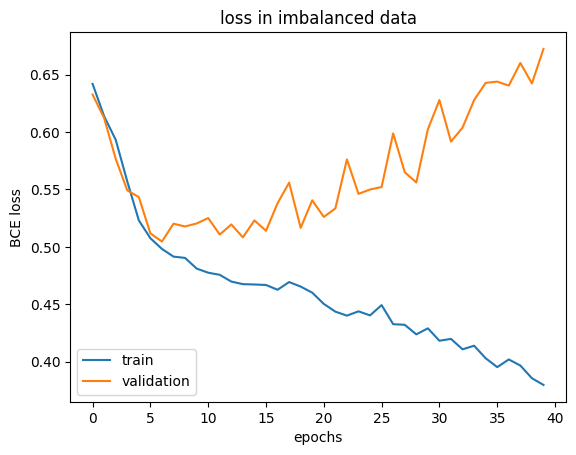

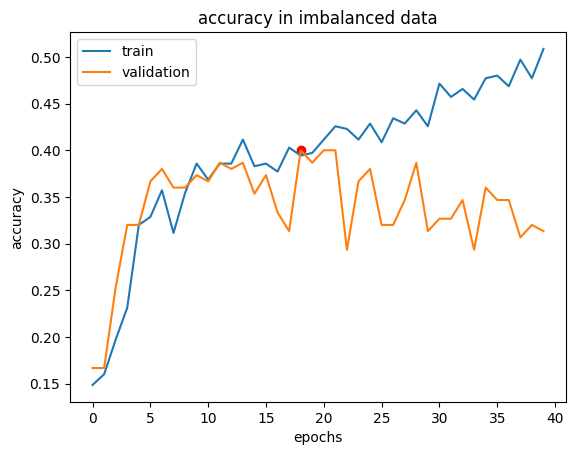

In [310]:
import matplotlib.pyplot as plt
 
plt.plot(train_loss_arr, label="train")
plt.plot(val_loss_arr, label="validation")
plt.xlabel("epochs")
plt.ylabel("BCE loss")
plt.title('loss in imbalanced data')
plt.legend()
plt.show()
 
plt.plot(train_accu_arr, label="train")
plt.plot(val_accu_arr, label="validation")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title('accuracy in imbalanced data')
plt.scatter(np.argmax(val_accu_arr), np.max(val_accu_arr), c='red')
#plt.annotate('Max val accuracy', xy=(np.argmax(val_accu_arr), np.max(val_accu_arr)),
             #xytext=(np.argmax(val_accu_arr)+0.1, np.max(val_accu_arr)+0.1))
plt.legend()
plt.show()

In [165]:
import platform
import psutil

# get the system hardware information
system = platform.uname()
cpu = platform.processor()
memory = psutil.virtual_memory()
disk = psutil.disk_usage('/')

# print the system hardware information
print(f"System: {system.system} {system.release} {system.version}")
print(f"CPU: {cpu}")
print(f"Memory: Total={memory.total / 1e9:.2f} GB, Available={memory.available / 1e9:.2f} GB")
print(f"Disk: Total={disk.total / 1e12:.2f} TB, Used={disk.used / 1e12:.2f} TB, Free={disk.free / 1e12:.2f} TB")

System: Linux 5.10.147+ #1 SMP Sat Dec 10 16:00:40 UTC 2022
CPU: x86_64
Memory: Total=13.62 GB, Available=11.23 GB
Disk: Total=0.24 TB, Used=0.03 TB, Free=0.22 TB


In [311]:

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
imbalanced_data = pd.read_csv('./data_imbalanced.csv')
X = imbalanced_data.drop(columns=['Unnamed: 0','Insominia', 'shizopherania',
       'vascula_demetia', 'ADHD', 'Bipolar'])
y = imbalanced_data[['Insominia', 'shizopherania',
       'vascula_demetia', 'ADHD', 'Bipolar']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=seed)
#Multilayer perceptron
MLP = MLPClassifier(random_state=seed).fit(X_train,y_train)
print("MLP accuracy :",MLP.score(X_test,y_test))

#Randowm Forest
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(random_state=seed).fit(X_train,y_train)
print("RF accuracy :",RF.score(X_test,y_test))

#Decision tree
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
print("DT accuracy :", clf.score(X_test,y_test))

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP accuracy : 0.4
RF accuracy : 0.32
DT accuracy : 0.24
